In [251]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import scipy.stats as st
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Import Dataset

In [3]:
# read raw data
df_raw = pd.read_csv('../Dataset/Coronna_Data_CERTAIN_raw.csv')

# Transform Dataset by futime

In [4]:
df_dev = df_raw.drop(columns=['Unnamed: 62', 'Unnamed: 63'])

In [5]:
# non_time_varying features
df_dev_demo = df_dev.iloc[:,:40]
df_dev_demo.columns
grp = df_dev_demo.set_index('futime').groupby('UNMC_id')
groups = [g.reindex(range(0, 15, 3)).fillna(method='ffill').reset_index() for _, g in grp]
demo_out = pd.concat(groups, ignore_index=True).reindex(df_dev_demo.columns, axis=1)
# demo_out

In [6]:
# time_varying features
df_dev_time_varying = df_dev.iloc[:,40:]
df_dev_time_varying['UNMC_id'] = df_dev['UNMC_id']
df_dev_time_varying['futime'] = df_dev['futime']
grp = df_dev_time_varying.set_index('futime').groupby('UNMC_id')
groups = [g.reindex(range(0, 15, 3)).reset_index() for _, g in grp]
time_varying_out = pd.concat(groups, ignore_index=True).reindex(df_dev_time_varying.columns, axis=1)
time_varying_out['UNMC_id'] = time_varying_out['UNMC_id'].fillna(method='ffill')
time_varying_out = time_varying_out.drop(columns=['futime','UNMC_id'])

In [7]:
# concat two feature subsets
out_final = pd.concat([demo_out,time_varying_out],axis=1)
out_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6145 entries, 0 to 6144
Data columns (total 62 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   UNMC_id            6145 non-null   object 
 1   grp                6145 non-null   object 
 2   init_group         6145 non-null   object 
 3   CDate              6145 non-null   object 
 4   futime             6145 non-null   int64  
 5   age                6140 non-null   float64
 6   gender             6140 non-null   object 
 7   final_education    6120 non-null   object 
 8   race_grp           6145 non-null   object 
 9   ethnicity          6050 non-null   float64
 10  weight             6140 non-null   float64
 11  BMI                6140 non-null   float64
 12  height             6145 non-null   float64
 13  newsmoker          6040 non-null   object 
 14  smkyrs             1745 non-null   float64
 15  numcigs            1705 non-null   float64
 16  drinker            6085 

In [8]:
# save to excel with sheetname based on months (0,3,6,9,12)
with pd.ExcelWriter("../Dataset/Coronna Data CERTAIN with SC edited.xlsx") as writer:
  out_final.to_excel(writer, sheet_name=f"all_fillna", header=True, index=False)
  for i in range(0, 15, 3):
    df = out_final[out_final['futime']==i]
    df.to_excel(writer, sheet_name=f"{i}M", header=True, index=False)

# Dataset Filter

In [101]:
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.preprocessing import scale

In [120]:
# Impute and export 0M+3M data
def calculate_DAS28_CRP(row):
    DAS28_CRP = 0.56*math.sqrt(row['tender_jts_28']) + 0.28*math.sqrt(row['swollen_jts_28']) + 0.014*row['pt_global_assess'] + 0.36*np.log(row['usresultsCRP']+1) + 0.96
    return DAS28_CRP

def impute_pt_global_assess(row):
    if pd.isna(row['pt_global_assess']) & pd.notna(row['md_global_assess']):
        return row['md_global_assess']
    else:
        return row['pt_global_assess']

def impute_DAS_28(df_to_impute):
    # impute pt_global_assess
    df_to_impute['pt_global_assess'] = df_to_impute.apply(lambda row: impute_pt_global_assess(row), axis = 1)
    # drop NaN in feautres used for calculating DAS-28
#     print(df_to_impute[(df_to_impute['tender_jts_28'].isnull()) | (df_to_impute['swollen_jts_28'].isnull()) | (df_to_impute['pt_global_assess'].isnull()) | (df_to_impute['usresultsCRP'].isnull())]['UNMC_id'])
    df_to_impute = df_to_impute.dropna(axis=0, subset=['tender_jts_28','swollen_jts_28','pt_global_assess','usresultsCRP'], thresh=3)
    df_to_impute = df_to_impute.reset_index(drop=True)
    # impute 'tender_jts_28','swollen_jts_28','usresultsCRP' if only one missing
    df_for_imputation = df_to_impute.drop(columns=['UNMC_id'])

    # tranform categorical features
    encoders = dict()
    for col_name in ['grp', 'init_group', 'ara_func_class', 'gender', 'final_education', 'race_grp', 'newsmoker', 'drinker']:
        series = df_for_imputation[col_name]
        label_encoder = preprocessing.LabelEncoder()
        df_for_imputation[col_name] = pd.Series(label_encoder.fit_transform(series[series.notnull()]),index=series[series.notnull()].index)
        encoders[col_name] = label_encoder

    imputer = KNNImputer(n_neighbors=50, weights="uniform")
    df_temp = pd.DataFrame(imputer.fit_transform(df_for_imputation))
    df_temp.columns = df_for_imputation.columns
    df_to_impute['tender_jts_28'] = df_temp['tender_jts_28']
    df_to_impute['swollen_jts_28'] = df_temp['swollen_jts_28']
    df_to_impute['pt_global_assess'] = df_temp['pt_global_assess']
    df_to_impute['usresultsCRP'] = df_temp['usresultsCRP']
    df_to_impute['DAS28_CRP'] = df_to_impute.apply(lambda row: calculate_DAS28_CRP(row), axis = 1)

    return df_to_impute

In [138]:
def create_dataframe(data_file, time_points, sample_list=[], init_group='all', save_file=False):
    approach = 'SC'
    time_1, time_2 = time_points
    df1 = data_file[data_file['futime']==time_1].drop(columns=['CDate','statin_use'])
    df2 = data_file[data_file['futime']==time_2].drop(columns=['CDate','statin_use'])
    
    imputed_1 = impute_DAS_28(df1)
#     imputed_1.info()
    imputed_2 = impute_DAS_28(df2)
#     imputed_2.info()
    imputed_2_selected = imputed_2[['UNMC_id','DAS28_CRP']]
    # merge target
    df_merged = pd.merge(imputed_1, imputed_2_selected, how="right", on="UNMC_id", suffixes= ("_0M","_3M"))
    # subset
    if init_group != 'all':
        df_merged = df_merged[df_merged['init_group']==init_group]
    if len(sample_list)>0:
        init_group = 'KVB'
        df_merged = df_merged[df_merged['UNMC_id'].isin(sample_list)]
    df_merged = df_merged.dropna(thresh=30)
#     df_merged.info()
    
    if save_file:
        file_loc = f'../Dataset/Coronna_Data_CERTAIN_{approach}_{time_1}M_{time_2}M_{init_group}.csv'
        print("save file to:",file_loc)
        df_merged.to_csv(file_loc,index=False)
    return df_merged

In [139]:
sample_list = list(pd.read_csv('../Dataset/Coronna_Data_CERTAIN_KVB_0M_3M.csv')['UNMC_id'])
new_df = create_dataframe(out_final, [0,3], sample_list, init_group='all', save_file=True)

save file to: ../Dataset/Coronna_Data_CERTAIN_SC_0M_3M_KVB.csv


In [140]:
new_df = create_dataframe(out_final, [0,3], init_group='all', save_file=True)

save file to: ../Dataset/Coronna_Data_CERTAIN_SC_0M_3M_all.csv


In [141]:
new_df = create_dataframe(out_final, [0,3], init_group='bionaive TNF', save_file=True)

save file to: ../Dataset/Coronna_Data_CERTAIN_SC_0M_3M_bionaive TNF.csv


# Change of DAS28_CRP across all time consecutive data

In [201]:
excel = pd.ExcelFile('../Dataset/Coronna Data CERTAIN with SC edited.xlsx')
df_use = pd.read_excel(excel, 'all_fillna')

In [202]:
# df_use = pd.read_csv('../Dataset/Coronna_Data_CERTAIN_raw.csv')
df_use = df_use[['UNMC_id','grp','init_group','futime','tender_jts_28','swollen_jts_28','pt_global_assess','usresultsCRP']]
df_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6145 entries, 0 to 6144
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   UNMC_id           6145 non-null   object 
 1   grp               6145 non-null   object 
 2   init_group        6145 non-null   object 
 3   futime            6145 non-null   int64  
 4   tender_jts_28     5416 non-null   float64
 5   swollen_jts_28    5416 non-null   float64
 6   pt_global_assess  5390 non-null   float64
 7   usresultsCRP      5278 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 384.2+ KB


In [203]:
# Calculate DAS-28-CRP
def calculate_DAS28_CRP(row):
    DAS28_CRP = 0.56*math.sqrt(row['tender_jts_28']) + 0.28*math.sqrt(row['swollen_jts_28']) + 0.014*row['pt_global_assess'] + 0.36*np.log(row['usresultsCRP']+1) + 0.96
    return DAS28_CRP
df_use['DAS28_CRP'] = df_use.apply(lambda row: calculate_DAS28_CRP(row), axis = 1)
df_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6145 entries, 0 to 6144
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   UNMC_id           6145 non-null   object 
 1   grp               6145 non-null   object 
 2   init_group        6145 non-null   object 
 3   futime            6145 non-null   int64  
 4   tender_jts_28     5416 non-null   float64
 5   swollen_jts_28    5416 non-null   float64
 6   pt_global_assess  5390 non-null   float64
 7   usresultsCRP      5278 non-null   float64
 8   DAS28_CRP         5247 non-null   float64
dtypes: float64(5), int64(1), object(3)
memory usage: 432.2+ KB


In [219]:
df_use.head(10)

,UNMC_id,grp,init_group,futime,tender_jts_28,swollen_jts_28,pt_global_assess,usresultsCRP,DAS28_CRP
0,U00001,orencia,bioexp nTNF,0,27.0,6.0,55.0,17.13,6.368827
1,U00001,orencia,bioexp nTNF,3,6.0,4.0,35.0,9.30,4.221286
2,U00001,orencia,bioexp nTNF,6,14.0,4.0,30.0,8.15,4.832280
3,U00001,orencia,bioexp nTNF,9,19.0,5.0,15.0,6.49,4.961967
4,U00001,orencia,bioexp nTNF,12,NaN,NaN,NaN,NaN,NaN
5,U00002,orencia,bioexp nTNF,0,8.0,10.0,90.0,5.56,5.366514
6,U00002,orencia,bioexp nTNF,3,3.0,12.0,50.0,10.86,4.490239
7,U00002,orencia,bioexp nTNF,6,0.0,9.0,35.0,13.83,3.260795
8,U00002,orencia,bioexp nTNF,9,15.0,12.0,60.0,NaN,NaN
9,U00002,orencia,bioexp nTNF,12,NaN,NaN,NaN,NaN,NaN


In [220]:
df_total = pd.DataFrame()

for UNMC_id in df_use['UNMC_id'].unique():
    df = df_use[df_use['UNMC_id']==UNMC_id]
    delta_DAS28_CRP_list = []
    for i in range(0, 12, 3):
        delta_DAS28_CRP_list.append((df[df['futime']==i]['DAS28_CRP'].values-df[df['futime']==i+3]['DAS28_CRP'].values))

    row_dict = {'UNMC_id':UNMC_id,
                'grp':df['grp'].iloc[0],
                'init_group':df['init_group'].iloc[0],
                'delta0-3M':delta_DAS28_CRP_list[0],
                'delta3-6M':delta_DAS28_CRP_list[1],
                'delta6-9M':delta_DAS28_CRP_list[2],
                'delta9-12M':delta_DAS28_CRP_list[3],
           }
    # row_dict.keys()
    df_sub_processed = pd.DataFrame.from_dict(row_dict)
    df_total = df_total.append(df_sub_processed,ignore_index=True)
df_total.head(20)

/var/folders/c9/_bb79xy945g7bvvn1rl6zsfr0000gn/T/ipykernel_18390/4233724787.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append(df_sub_processed,ignore_index=True)


,UNMC_id,grp,init_group,delta0-3M,delta3-6M,delta6-9M,delta9-12M
0,U00001,orencia,bioexp nTNF,2.147541,-0.610993,-0.129688,NaN
1,U00002,orencia,bioexp nTNF,0.876275,1.229444,NaN,NaN
2,U00003,enbrel,bionaive TNF,1.456239,-0.179027,0.470125,-0.696671
3,U00004,actemra,bioexp nTNF,0.248375,1.137420,0.393015,NaN
4,U00005,rituxan,bioexp nTNF,1.485014,1.243824,-1.542413,0.814460
5,U00006,rituxan,bioexp nTNF,2.391659,-1.494217,1.937701,-1.399463
6,U00007,actemra,bioexp nTNF,2.638666,-0.269680,-1.943085,0.379234
7,U00008,orencia,bioexp nTNF,0.360126,-0.216526,-0.297021,0.652536
8,U00009,rituxan,bioexp nTNF,0.732070,0.358420,1.122954,-0.503230
9,U00010,actemra,bioexp nTNF,0.048641,0.134566,0.210492,0.865930


In [309]:
def statistical_table(df_total):
    final_results = pd.DataFrame(columns=['init_group','grp','delta_months','mean','std','interval_low','interval_up'])
    for init_group in df_total['init_group'].unique():
        for grp in df_total['grp'].unique():
            for delta_months in ['delta0-3M','delta3-6M','delta6-9M','delta9-12M']:
                data = df_total[(df_total['init_group']==init_group) & (df_total['grp']==grp)][delta_months]
                data = data.dropna()
                results_list = [init_group,grp,
                                delta_months,
                                np.mean(data,axis=0),
                                np.std(data,axis=0),
                                st.norm.interval(alpha=0.95, loc=np.mean(data), scale=st.sem(data))[0],
                                st.norm.interval(alpha=0.95, loc=np.mean(data), scale=st.sem(data))[1],
                               ]
                final_results.loc[len(final_results)] = results_list
                
    return final_results

df_stat = statistical_table(df_total)

/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value

In [310]:
df_stat

,init_group,grp,delta_months,mean,std,interval_low,interval_up
0,bioexp nTNF,orencia,delta0-3M,0.998483,1.207795,0.854684,1.142282
1,bioexp nTNF,orencia,delta3-6M,0.167666,1.150321,0.030962,0.304371
2,bioexp nTNF,orencia,delta6-9M,-0.090362,1.094139,-0.233967,0.053242
3,bioexp nTNF,orencia,delta9-12M,-0.049333,1.053378,-0.200310,0.101644
4,bioexp nTNF,enbrel,delta0-3M,NaN,NaN,NaN,NaN
5,bioexp nTNF,enbrel,delta3-6M,NaN,NaN,NaN,NaN
6,bioexp nTNF,enbrel,delta6-9M,NaN,NaN,NaN,NaN
7,bioexp nTNF,enbrel,delta9-12M,NaN,NaN,NaN,NaN
8,bioexp nTNF,actemra,delta0-3M,1.329825,1.242389,1.180803,1.478847
9,bioexp nTNF,actemra,delta3-6M,0.162320,1.251411,0.013328,0.311313


In [216]:
df_total.to_csv('../Dataset/delta_DAS28_all.csv',index=False)

In [325]:
df_stat.to_csv('../Dataset/delta_DAS28_all_stat.csv',index=False)

In [282]:
df_total[df_total['init_group']=='bionaive TNF']['grp'].value_counts()

humira      168
enbrel      132
remicade     92
cimzia       35
simponi       8
Name: grp, dtype: int64

In [307]:
np.asarray(df_stat[(df_stat['init_group']==init_group)&(df_stat['grp']==grp)]['interval'])

array([(nan, nan), (nan, nan), (nan, nan), (nan, nan)], dtype=object)

In [314]:
df_stat_dev

,init_group,grp,delta_months,mean,std,interval_low,interval_up
60,bionaive TNF,simponi,delta0-3M,1.197328,0.741698,0.647880,1.746776
61,bionaive TNF,simponi,delta3-6M,0.298561,0.616577,-0.158197,0.755319
62,bionaive TNF,simponi,delta6-9M,-0.512759,0.920851,-1.319905,0.294387
63,bionaive TNF,simponi,delta9-12M,0.322225,1.240071,-0.764725,1.409176


<Figure size 432x288 with 0 Axes>

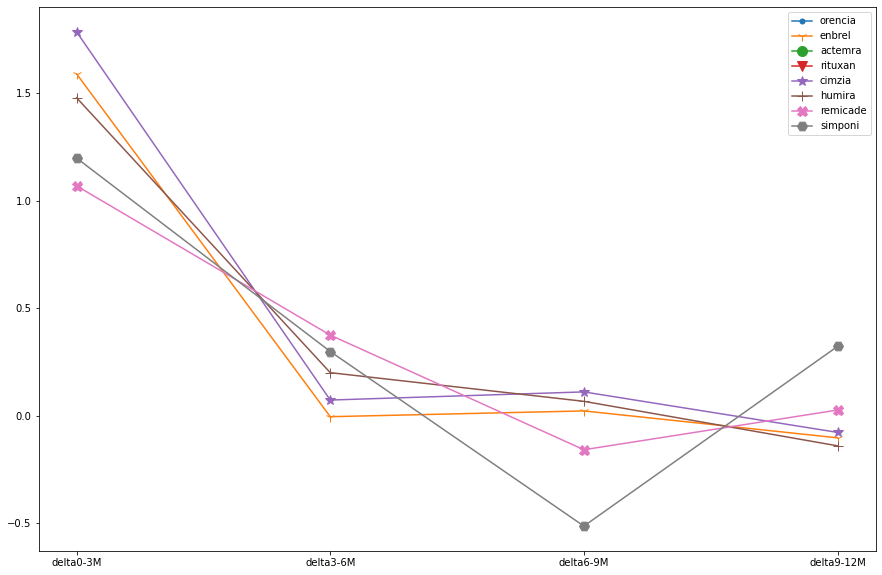

In [324]:
fig = plt.figure()
init_group = 'bionaive TNF'
plt.figure(figsize=(15,10))
marker_list = [".","1","o","v","*","+","X","H"]
for grp,marker in zip(df_total['grp'].unique(),marker_list):
    df_stat_dev = df_stat[(df_stat['init_group']==init_group)&(df_stat['grp']==grp)]
    plt.errorbar(x=df_stat_dev['delta_months'],
                 y=df_stat_dev['mean'],
                 marker = marker,
                 markersize = 10,
#                  yerr=df_stat_dev[['interval_low','interval_up']].transpose(),
                 label=grp)
plt.legend(loc=1)
plt.show()

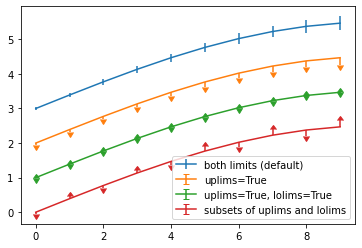

In [275]:
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure()
x = np.arange(10)
y = 2.5 * np.sin(x / 20 * np.pi)
yerr = np.linspace(0.05, 0.2, 10)

plt.errorbar(x, y + 3, yerr=yerr, label='both limits (default)')

plt.errorbar(x, y + 2, yerr=yerr, uplims=True, label='uplims=True')

plt.errorbar(x, y + 1, yerr=yerr, uplims=True, lolims=True,
             label='uplims=True, lolims=True')

upperlimits = [True, False] * 5
lowerlimits = [False, True] * 5
plt.errorbar(x, y, yerr=yerr, uplims=upperlimits, lolims=lowerlimits,
             label='subsets of uplims and lolims')

plt.legend(loc='lower right')